In [1]:
!pip install kagglehub pandas numpy matplotlib seaborn scikit-learn statsmodels tensorflow


In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
import kagglehub
import os

warnings.filterwarnings('ignore')

# Set plot styles
plt.style.use('default')
sns.set_palette("husl")

print("✓ STEP 1: Libraries imported and settings configured successfully!")


✓ STEP 1: Libraries imported and settings configured successfully!


In [3]:
# STEP 2: Data Loading and Preprocessing
print("\n=== STEP 2: Starting Data Loading and Preprocessing ===")
# Download the dataset from KaggleHub
path = kagglehub.dataset_download('anikannal/solar-power-generation-data')
print(f"Dataset downloaded to: {path}")

# Load the data
plant1_gen = pd.read_csv(f'{path}/Plant_1_Generation_Data.csv')
plant1_weather = pd.read_csv(f'{path}/Plant_1_Weather_Sensor_Data.csv')
plant2_gen = pd.read_csv(f'{path}/Plant_2_Generation_Data.csv')
plant2_weather = pd.read_csv(f'{path}/Plant_2_Weather_Sensor_Data.csv')

# Smart datetime conversion function
def convert_datetime(df):
    try:
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%d-%m-%Y %H:%M')
    except:
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Convert datetime columns for all dataframes
for df in [plant1_gen, plant1_weather, plant2_gen, plant2_weather]:
    convert_datetime(df)

# Merge generation and weather data
plant1_df = pd.merge(plant1_gen, plant1_weather, on='DATE_TIME', how='inner')
plant2_df = pd.merge(plant2_gen, plant2_weather, on='DATE_TIME', how='inner')

# Calculate conversion efficiency and clean the data
plant1_df['EFFICIENCY'] = plant1_df['AC_POWER'] / plant1_df['DC_POWER']
plant2_df['EFFICIENCY'] = plant2_df['AC_POWER'] / plant2_df['DC_POWER']
plant1_df.replace([np.inf, -np.inf], np.nan, inplace=True)
plant2_df.replace([np.inf, -np.inf], np.nan, inplace=True)
plant1_df_clean = plant1_df[(plant1_df['EFFICIENCY'] > 0) & (plant1_df['EFFICIENCY'] < 1)].copy()
plant2_df_clean = plant2_df[(plant2_df['EFFICIENCY'] > 0) & (plant2_df['EFFICIENCY'] < 1)].copy()

print("✓ STEP 2: Data loading and preprocessing complete!")



=== STEP 2: Starting Data Loading and Preprocessing ===


100%|██████████| 1.90M/1.90M [00:00<00:00, 2.38MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/anikannal/solar-power-generation-data/versions/1
✓ STEP 2: Data loading and preprocessing complete!


In [4]:
# STEP 3: Feature Engineering
print("\n=== STEP 3: Starting Feature Engineering ===")
def create_features(df, plant_id):
    df = df.copy()
    df = df.set_index('DATE_TIME')
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['temp_diff'] = df['MODULE_TEMPERATURE'] - df['AMBIENT_TEMPERATURE']
    df['irradiation_per_temp'] = df['IRRADIATION'] / (df['AMBIENT_TEMPERATURE'] + 273.15)
    df = df.dropna()
    print(f"Feature engineering for Plant {plant_id} complete.")
    return df

plant1_processed = create_features(plant1_df_clean, 1)
plant2_processed = create_features(plant2_df_clean, 2)

print("✓ STEP 3: Feature engineering complete!")


=== STEP 3: Starting Feature Engineering ===
Feature engineering for Plant 1 complete.
Feature engineering for Plant 2 complete.
✓ STEP 3: Feature engineering complete!



=== STEP 4: Starting Power Forecasting Analysis ===
Training set size: 29783, Test set size: 2235
Training SARIMAX model...
Making SARIMAX predictions...
Creating and training LSTM model...
Starting LSTM training, this may take a few minutes...
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

SARIMAX - MAE: 140.10, RMSE: 171.01
LSTM - MAE: 26.42, RMSE: 50.58


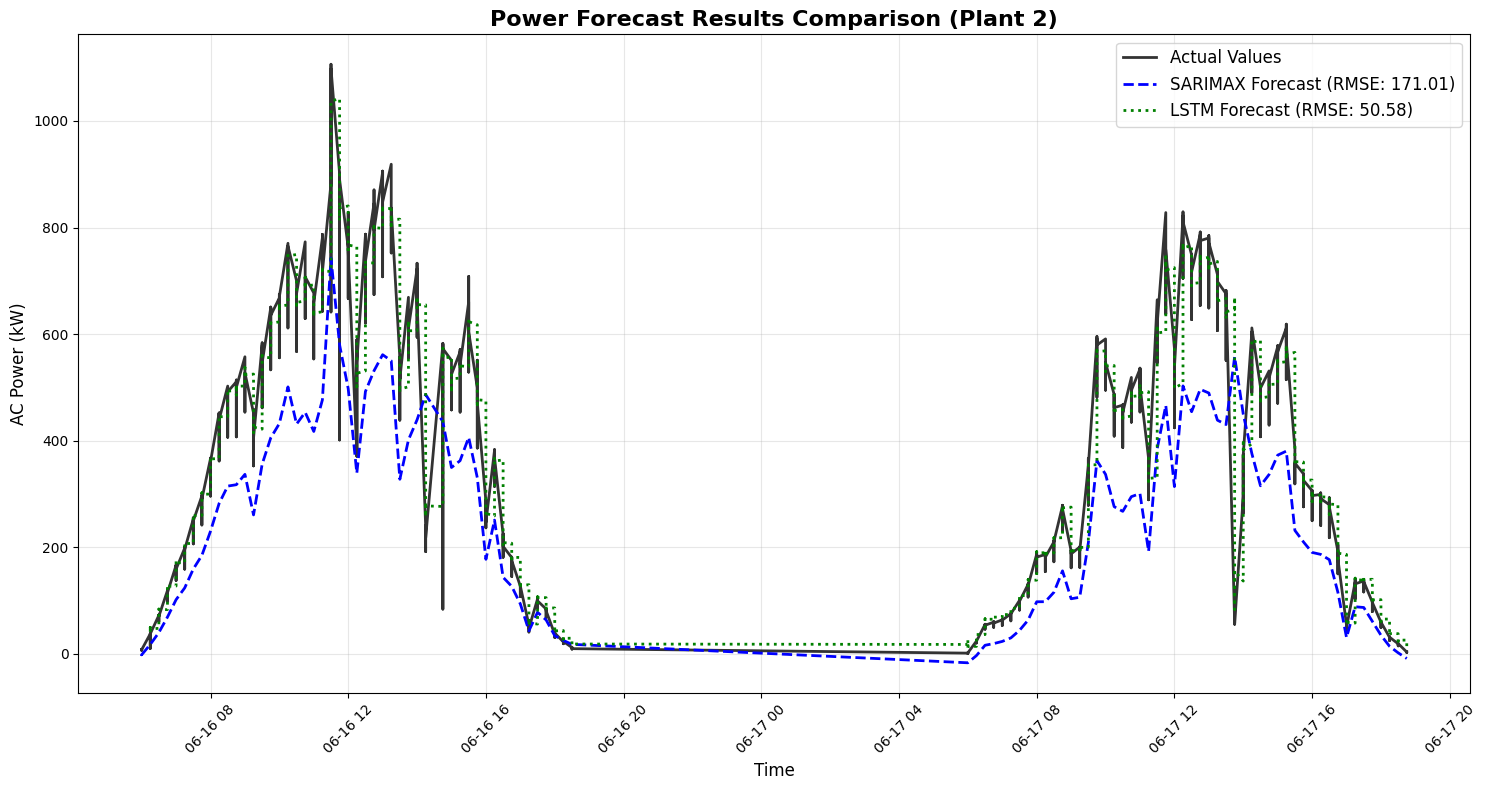

✓ STEP 4: Power forecasting and visualization complete!


In [5]:
# STEP 4: Power Generation Forecasting Models (SARIMAX & LSTM)
print("\n=== STEP 4: Starting Power Forecasting Analysis ===")

class SimplePowerPredictor:
    def __init__(self, data):
        self.data = data.copy()
        self.train_data = None
        self.test_data = None
        self.sarimax_model = None
        self.lstm_model = None
        self.scaler = MinMaxScaler()
        self.results = {}

    def split_data(self, test_days=2):
        split_date = self.data.index.max() - pd.Timedelta(days=test_days)
        self.train_data = self.data[self.data.index <= split_date]
        self.test_data = self.data[self.data.index > split_date]
        print(f"Training set size: {len(self.train_data)}, Test set size: {len(self.test_data)}")

    def train_sarimax(self):
        print("Training SARIMAX model...")
        exog_cols = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
        self.sarimax_model = SARIMAX(
            self.train_data['AC_POWER'],
            exog=self.train_data[exog_cols],
            order=(1, 1, 1),
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

    def predict_sarimax(self):
        print("Making SARIMAX predictions...")
        exog_cols = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']
        forecast = self.sarimax_model.get_forecast(
            steps=len(self.test_data),
            exog=self.test_data[exog_cols]
        )
        predictions = forecast.predicted_mean
        predictions.index = self.test_data.index
        self.results['sarimax_preds'] = predictions
        return predictions

    def create_lstm_predictions(self):
        print("Creating and training LSTM model...")
        features = ['AC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'hour']

        scaled_train = self.scaler.fit_transform(self.train_data[features])
        scaled_test = self.scaler.transform(self.test_data[features])

        def create_dataset(dataset, look_back=1):
            X, Y = [], []
            for i in range(len(dataset) - look_back):
                X.append(dataset[i:(i + look_back), :])
                Y.append(dataset[i + look_back, 0])
            return np.array(X), np.array(Y)

        look_back = 24
        X_train, y_train = create_dataset(scaled_train, look_back)
        X_test, y_test = create_dataset(scaled_test, look_back)

        self.lstm_model = Sequential()
        self.lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        self.lstm_model.add(Dropout(0.2))
        self.lstm_model.add(LSTM(50))
        self.lstm_model.add(Dropout(0.2))
        self.lstm_model.add(Dense(1))
        self.lstm_model.compile(optimizer='adam', loss='mean_squared_error')

        print("Starting LSTM training, this may take a few minutes...")
        self.lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

        lstm_preds_scaled = self.lstm_model.predict(X_test)

        dummy_array = np.zeros((len(lstm_preds_scaled), len(features)))
        dummy_array[:, 0] = lstm_preds_scaled.ravel()
        predictions_inversed = self.scaler.inverse_transform(dummy_array)[:, 0]

        lstm_preds = pd.Series(predictions_inversed, index=self.test_data.index[look_back:])
        self.results['lstm_preds'] = lstm_preds
        return lstm_preds

    def evaluate_models(self):
        test_actual_sarimax = self.test_data['AC_POWER']
        test_actual_lstm = self.test_data['AC_POWER'].iloc[24:]

        sarimax_preds = self.results['sarimax_preds']
        sarimax_mae = mean_absolute_error(test_actual_sarimax, sarimax_preds)
        sarimax_rmse = np.sqrt(mean_squared_error(test_actual_sarimax, sarimax_preds))

        lstm_preds = self.results['lstm_preds']
        lstm_mae = mean_absolute_error(test_actual_lstm, lstm_preds)
        lstm_rmse = np.sqrt(mean_squared_error(test_actual_lstm, lstm_preds))

        self.results.update({
            'sarimax_mae': sarimax_mae, 'sarimax_rmse': sarimax_rmse,
            'lstm_mae': lstm_mae, 'lstm_rmse': lstm_rmse
        })

        print(f"\nSARIMAX - MAE: {sarimax_mae:.2f}, RMSE: {sarimax_rmse:.2f}")
        print(f"LSTM - MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}")

        return {
            'sarimax': {'mae': sarimax_mae, 'rmse': sarimax_rmse},
            'lstm': {'mae': lstm_mae, 'rmse': lstm_rmse}
        }

# --- Execute Forecasting ---
predictor = SimplePowerPredictor(plant2_processed)
predictor.split_data(test_days=2)
predictor.train_sarimax()
predictor.predict_sarimax()
predictor.create_lstm_predictions()
performance = predictor.evaluate_models()

# --- Visualize Forecasting Results ---
plt.figure(figsize=(15, 8))
test_actual = predictor.test_data['AC_POWER']
sarimax_rmse = predictor.results['sarimax_rmse']
lstm_rmse = predictor.results['lstm_rmse']
plt.plot(test_actual.index, test_actual.values, label="Actual Values", color="black", linewidth=2, alpha=0.8)
plt.plot(predictor.results['sarimax_preds'].index, predictor.results['sarimax_preds'].values, label=f"SARIMAX Forecast (RMSE: {sarimax_rmse:.2f})", color="blue", linestyle="--", linewidth=2)
plt.plot(predictor.results['lstm_preds'].index, predictor.results['lstm_preds'].values, label=f"LSTM Forecast (RMSE: {lstm_rmse:.2f})", color="green", linestyle=":", linewidth=2)
plt.title("Power Forecast Results Comparison (Plant 2)", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("AC Power (kW)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("✓ STEP 4: Power forecasting and visualization complete!")



=== STEP 5: Starting Equipment Fault Detection Analysis ===
--- Statistical Method Analysis ---
Identified 0 potentially faulty inverters via statistical method.
--- Isolation Forest Anomaly Detection ---
Isolation Forest detected 10.00% of data points as anomalies.
--- K-Means Clustering Analysis ---
K-Means grouped inverters into 4 clusters. Cluster 0 has the lowest efficiency.


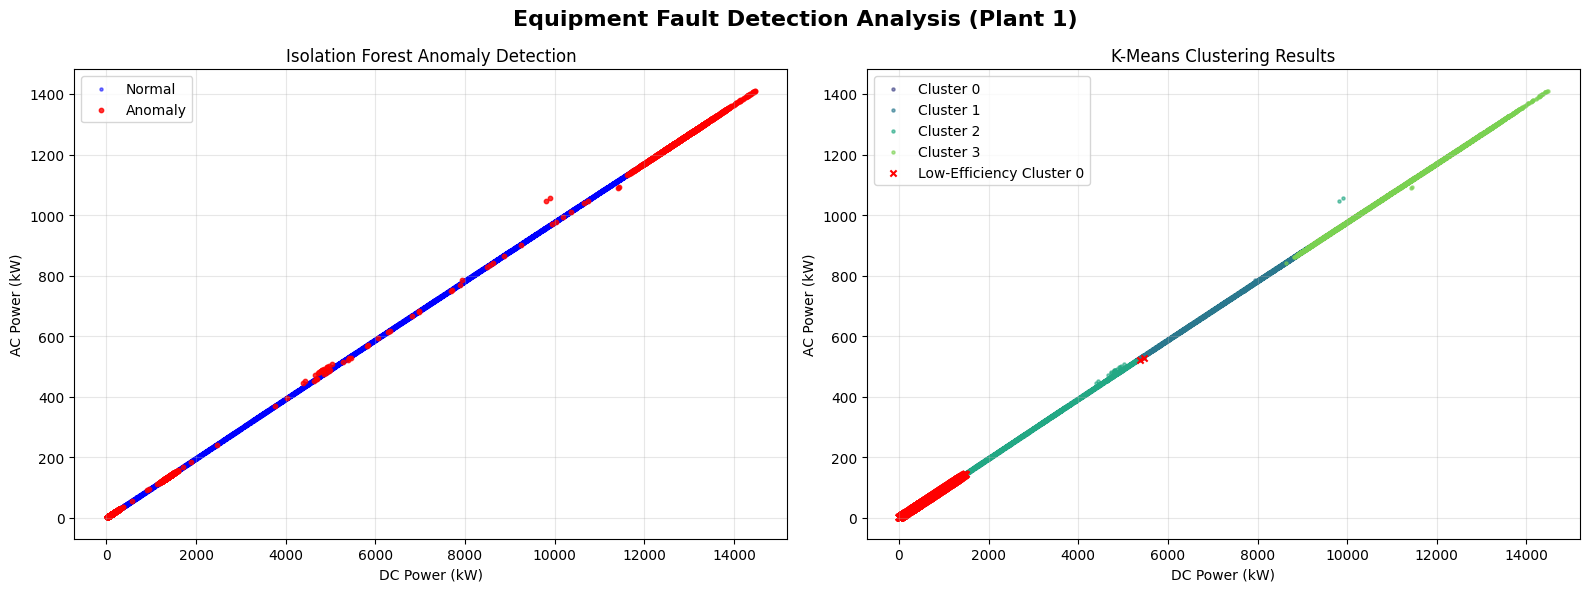

✓ STEP 5: Fault detection and visualization complete!

=== Entire Project Analysis Complete ===


In [7]:
# STEP 5: Equipment Fault Detection
print("\n=== STEP 5: Starting Equipment Fault Detection Analysis ===")

class FaultDetector:
    def __init__(self, plant1_data):
        self.plant1_data = plant1_data.copy()
        self.results = {}
        self.scaler = StandardScaler()

    def statistical_analysis(self):
        print("--- Statistical Method Analysis ---")
        inverter_stats = self.plant1_data.groupby('SOURCE_KEY_x')['EFFICIENCY'].agg(['mean', 'std']).dropna()
        threshold = inverter_stats['mean'].mean() - 2 * inverter_stats['std'].mean()
        faulty_inverters = inverter_stats[inverter_stats['mean'] < threshold]
        self.results['statistical'] = {'faulty_inverters_count': len(faulty_inverters), 'faulty_inverters_list': faulty_inverters.index.tolist()}
        print(f"Identified {len(faulty_inverters)} potentially faulty inverters via statistical method.")
        return faulty_inverters

    def isolation_forest_analysis(self):
        print("--- Isolation Forest Anomaly Detection ---")
        features = ['DC_POWER', 'AC_POWER', 'EFFICIENCY']
        plant1_features = self.plant1_data[features].dropna()
        plant1_scaled = self.scaler.fit_transform(plant1_features)

        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        anomalies = iso_forest.fit_predict(plant1_scaled)

        plant1_features['anomaly'] = anomalies
        anomaly_rate = np.sum(anomalies == -1) / len(anomalies)
        self.results['isolation_forest'] = {'anomaly_rate': anomaly_rate}
        print(f"Isolation Forest detected {anomaly_rate:.2%} of data points as anomalies.")
        return plant1_features

    def kmeans_analysis(self, data):
        print("--- K-Means Clustering Analysis ---")
        features = ['DC_POWER', 'AC_POWER', 'EFFICIENCY']
        X_scaled = self.scaler.fit_transform(data[features])

        best_k = 4 # Using a fixed K for simplicity
        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        data['cluster'] = kmeans.fit_predict(X_scaled)

        cluster_efficiency = data.groupby('cluster')['EFFICIENCY'].mean()
        faulty_cluster = cluster_efficiency.idxmin()
        self.results['kmeans'] = {'best_k': best_k, 'faulty_cluster': faulty_cluster, 'faulty_cluster_efficiency': cluster_efficiency.min()}
        print(f"K-Means grouped inverters into {best_k} clusters. Cluster {faulty_cluster} has the lowest efficiency.")
        return data

# --- Execute Fault Detection ---
detector = FaultDetector(plant1_df_clean)
faulty_by_stat = detector.statistical_analysis()
plant1_anomalies = detector.isolation_forest_analysis()
plant1_clusters = detector.kmeans_analysis(plant1_anomalies)

# --- Visualize Fault Detection Results ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Equipment Fault Detection Analysis (Plant 1)', fontsize=16, fontweight='bold')

# Isolation Forest Results
normal_data = plant1_anomalies[plant1_anomalies['anomaly'] == 1]
anomaly_data = plant1_anomalies[plant1_anomalies['anomaly'] == -1]
axes[0].scatter(normal_data['DC_POWER'], normal_data['AC_POWER'], c='blue', alpha=0.5, s=5, label='Normal')
axes[0].scatter(anomaly_data['DC_POWER'], anomaly_data['AC_POWER'], c='red', alpha=0.8, s=10, label='Anomaly')
axes[0].set_title('Isolation Forest Anomaly Detection')
axes[0].set_xlabel('DC Power (kW)')
axes[0].set_ylabel('AC Power (kW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# K-Means Clustering Results
colors = sns.color_palette('viridis', detector.results['kmeans']['best_k'])
for i in range(detector.results['kmeans']['best_k']):
    cluster_data = plant1_clusters[plant1_clusters['cluster'] == i]
    axes[1].scatter(cluster_data['DC_POWER'], cluster_data['AC_POWER'], color=colors[i], alpha=0.6, s=5, label=f'Cluster {i}')
faulty_cluster_id = detector.results['kmeans']['faulty_cluster']
faulty_data = plant1_clusters[plant1_clusters['cluster'] == faulty_cluster_id]
axes[1].scatter(faulty_data['DC_POWER'], faulty_data['AC_POWER'], color='red', s=20, marker='x', label=f'Low-Efficiency Cluster {faulty_cluster_id}')
axes[1].set_title('K-Means Clustering Results')
axes[1].set_xlabel('DC Power (kW)')
axes[1].set_ylabel('AC Power (kW)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ STEP 5: Fault detection and visualization complete!")
print("\n=== Entire Project Analysis Complete ===")